## Plan du travail

Le Projet consiste à étudier la vente des médicaments et implémenter des modèles de prédictions pouvant permettre de préduire le comportement à l'avenir en fonction des comportements passés et actuels en utilisant des notions de séries temporelles.

Pour ce fait, nous allons parcourir différentes notions vues au cours allant de l'analyse basique des séries temporelles, à leurs modélisations avec différentes approches à savoir la méthode statisque et la méthode d'apprentissage profond. Mais aussi déffinir des mésures de précision permettant des voir quel modèle implémenté semble meilleur que l'autre en fonction des données que contient notre dataset.

Avant d'aller plus loin, il est important d'appréhender certaines notions liées à ce travail facilant sa compréhension.

**C'est quoi une série temporelle ou chronologique ?**

>`Une série chronologique` est définie comme une série de points de données enregistrés à différents intervalles de temps. L'ordre chronologique peut être quotidien, mensuel ou même annuel.

**Qu'entends-t-on par prévion des séries temporelles ?**

>`La prévision des séries temporelles` est le processus qui consiste à utiliser un modèle statistique pour prédire les valeurs futures d'une série temporelle sur la base des résultats passés. De manière plus simple, c'est l'étape où nous voulons prédire les valeurs futures que la série va prendre.

**Combien de catégories de prévisions existe-t-il ?**

>La prévision d'une série chronologique peut être divisée en deux grandes catégories.

* Si nous n'utilisons que les valeurs précédentes de la série temporelle pour prédire ses valeurs futures, il s'agit d'une `prévision de série temporelle univariée`.

* Si nous utilisons des prédicteurs autres que la série (comme les variables exogènes) pour prévoir, on parle de `prévision de séries temporelles multi-variées`.

**Table des matières**

1. [Analyse Fondamentale](#BasicAnalytics)
    * [Préparation des données](#DataPreparation)
    * [Visualisation des données](#DataVisualization)
    * [Séparation des donnnées](#DataSplitting)
    * [Décomposition des séries temporelles](#TimeSeriesDecomposition)

2. [Mesures de Précision pour les prévisions des séries temporelles](#AccuracyMetrics)

3. [Modélisation des séries chronologiques avec la méthode statistique](#TimeSeriesModelingwithStatisticalMethod)
    * [Naive Forecast](#NaiveForecast)
    * [Moyenne mobile exponentielle](#ExponentialMovingAverage)
        * [Moyenne mobile exponentielle simple (SEMA)](#SimpleExponentialMovingAverage(SEMA))
        * [Méthode de la moyenne mobile exponentielle Holt-Winters](#Holt-WintersMethod)
    * [ARIMA Forecast](#ARIMAForecast)
    * [SARIMA Forecast](#SARIMAForecast)
    
4. [Modélisation des séries temporelles avec le Deep Learning](#TimeSeriesModelingwithDeepLearning)
    * [Prétraitement des données](#Preprocessing)
    * [MLP](#MLP)
        * [Modélisation](#ModelingMLP)
        * [Formation](#TrainingMLP)
        * [Evaluation](#EvaluationMLP)
    * [LSTM](#LSTM)
        * [Modélisation](#ModelingLSTM)
        * [Formation](#TrainingLSTM)
        * [Evaluation](#EvaluationLSTM)

5. [Conclusion](#Conclusion)



In [ ]:
from google.colab import drive
drive.mount('/content/Dataset')

In [2]:
# Import packages
import math
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from numpy import log
import statsmodels.api as sm
from matplotlib import pylab
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from torch.utils.data import Dataset, DataLoader, TensorDataset
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

%matplotlib inline 
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import warnings
warnings.filterwarnings("ignore")

## <a name="BasicAnalytics">1. Analyse Fondamentale</a>

### <a name="DataPreparation">a - Préparation et visualisation des données
Importons le dataset et faisons de la colonne `Date` l'index puis définissons la fréquence

#### **Préparation des données**

In [4]:
# Importons le CSV
medoc_df = pd.read_csv("/Users/harouna/Documents/Horizon/Time Series/Time_Series_Projet/data/drug_sales.txt")
df = medoc_df
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.index.freq ='MS'
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [5]:
df.shape

(204, 1)

#### **Visualisation des données**

Text(0, 0.5, 'Ventes au détail mensuelles')

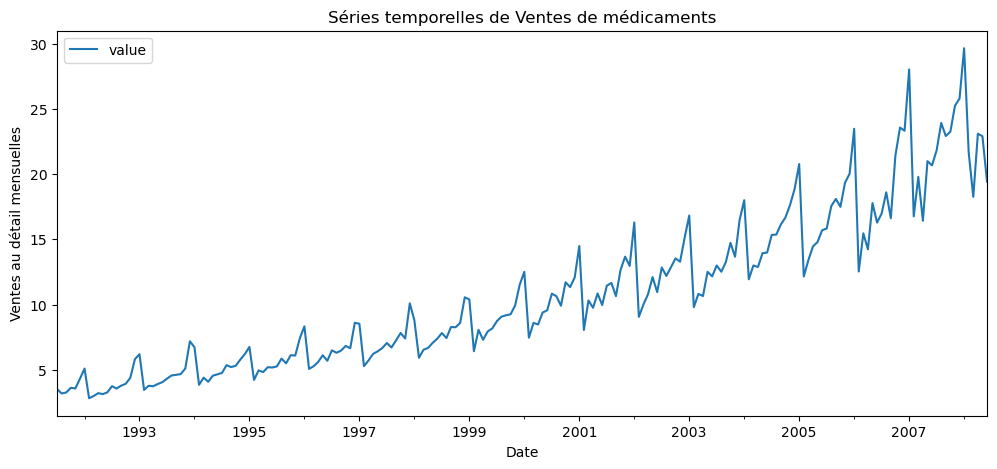

In [6]:
# Visualisons nos séries
df.plot(figsize=(12,5))
plt.title("Séries temporelles de Ventes de médicaments")
plt.xlabel("Date")
plt.ylabel("Ventes au détail mensuelles")

### <a name="DataSplitting">b - Séparation des données
Diviser les données en données de formation et de test en utilisant `train_test_split`.

Comme notre dataset comportes des données sur 204 mois, utilisons les 180 prémiers mois comme données de formation et les 24 derniers mois comme donnée de test hors du temps.

In [7]:
# Créer des données de formations et de tests
split_ratio = 0.885
train, test = train_test_split(df, train_size=split_ratio , shuffle = False)
train_time,test_time = train.index, test.index

#print(train.shape)
#print(test.shape)

### <a name="TimeSeriesDecomposition">c - Décomposition des séries temporelles
La décomposition nous donne plus de détails sur le modèle de données des séries chronologiques en décomposant les données en `tendance`, `saisonnalité` et `résidu`.

#### **Decomposition additive**

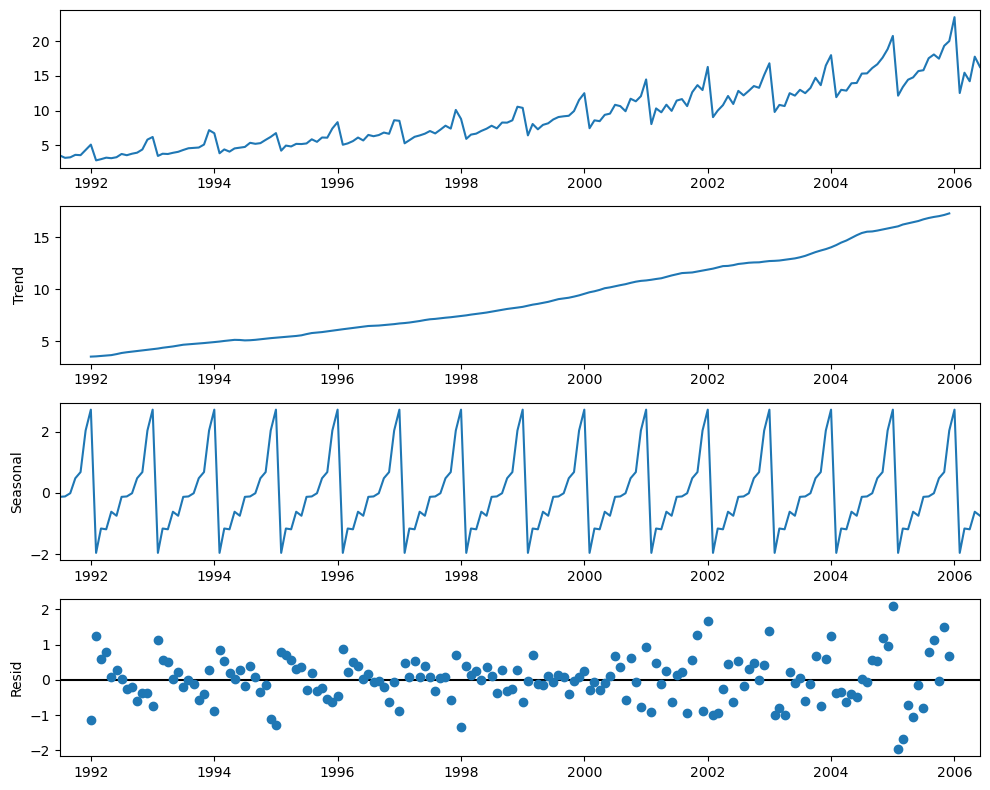

In [8]:
# Decomposition additive
add_decomposition = seasonal_decompose(train, model='additive')
add_decomposition.plot()

plt.show()

#### **Decomposition multiplicative**

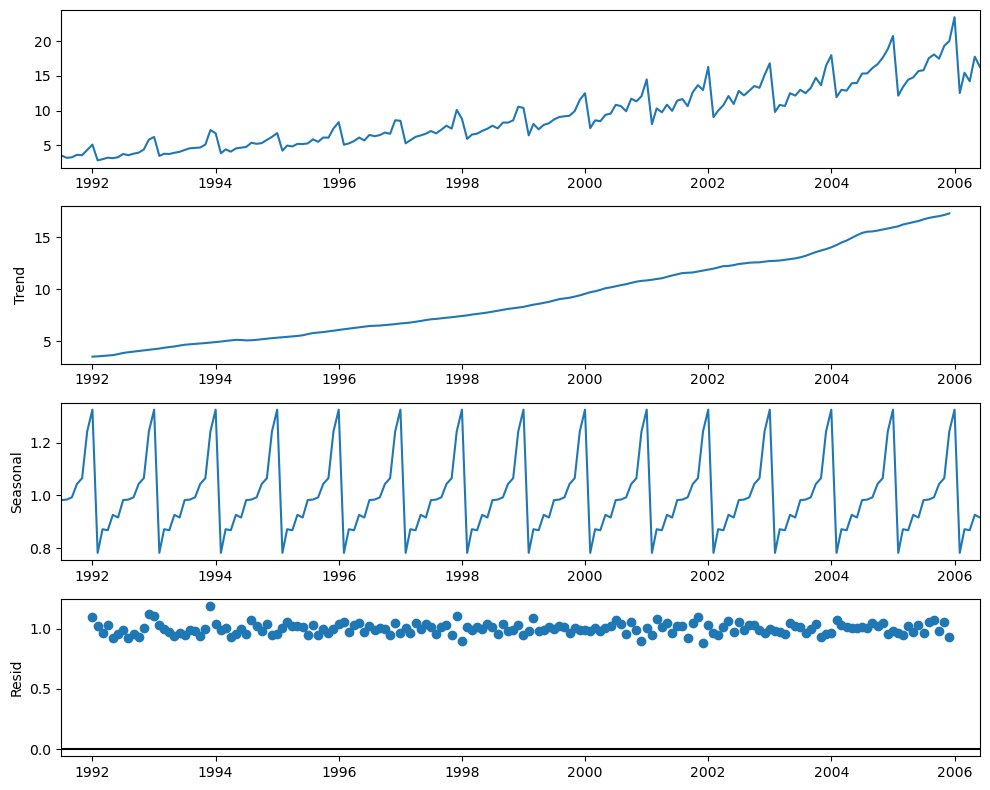

In [9]:
# Decomposition multiplicative
mul_decomposition = seasonal_decompose(train, model='multiplicative')
mul_decomposition.plot()

plt.show()

## <a name="AccuracyMetrics">2. Mesures de Précision pour les prévisions des séries temporelles

In [10]:
# Calculer des metriques des modèles chosis
def forcast_accuracy(forecast, actual):
    #mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return rmse#({'mape':mape,'rmse':rmse,'corr':corr})

## <a name="TimeSeriesModelingwithStatisticalMethod">3. Modélisation des séries chronologiques avec la méthode statistique

#### **Fonction de traçage des données de prévisions**

In [11]:
# Fonction pour tracer les données de la prévision
def forecast_plot(forecast_data,forecast_label, test_label='Test Data',test_time = test_time,test_data= test):
    plt.figure(figsize=(12,6))
    plt.plot(test_time,forecast_data,'y',label = forecast_label,)
    plt.plot(test_time,test_data,label = test_label)
    plt.legend()
    plt.title("Prédiction")
    plt.xlabel("Mois")
    plt.ylabel("Ventes au détail")

### <a name="NaiveForecast">a - Naive Forecast
Tout d'abord, utilisons la méthode de prévision naïve comme modèle de référence.

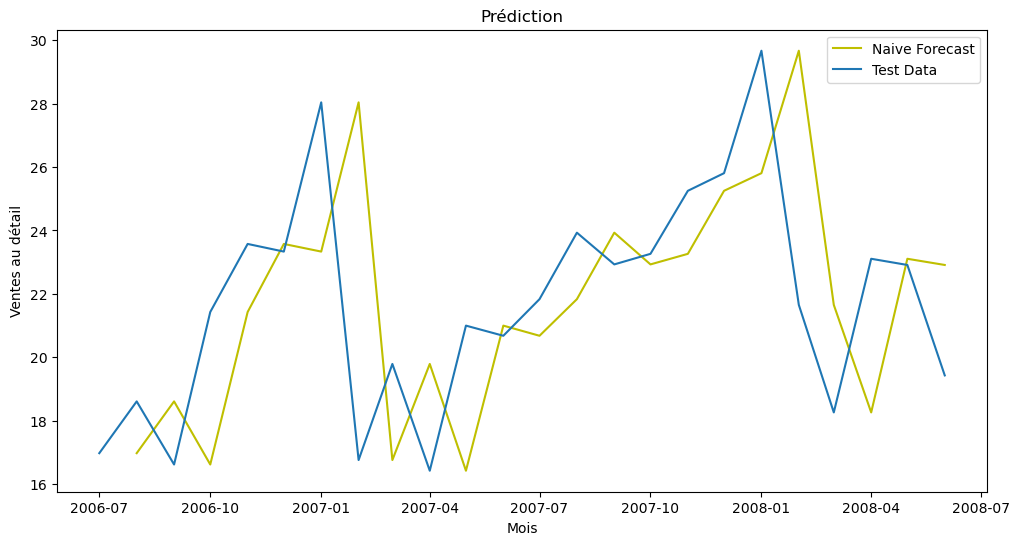

In [12]:
# Tracer les données de la prévision
# Méthode de prévision naïve 
naive_forecast = test.shift(1)
forecast_plot(forecast_data = naive_forecast,forecast_label = 'Naive Forecast')

In [13]:
# Sauvegarder le résultat dans un Dataframe nommé P
Naïve_acc = forcast_accuracy(naive_forecast, test).value
Precision = pd.DataFrame({'NAÏVE ACC' :Naïve_acc},index=["RMSE"])
Precision

,NAÏVE ACC
RMSE,3.969457


### <a name="ExponentialMovingAverage">b - Moyenne mobile exponentielle

#### <a name="SimpleExponentialMovingAverage(SEMA)">1 - Moyenne mobile exponentielle simple (SEMA)
Commençons par la moyenne mobile exponentielle simple (SEMA) pour déterminer si cette méthode est la bonne méthode à utiliser comme modèle de prévision.

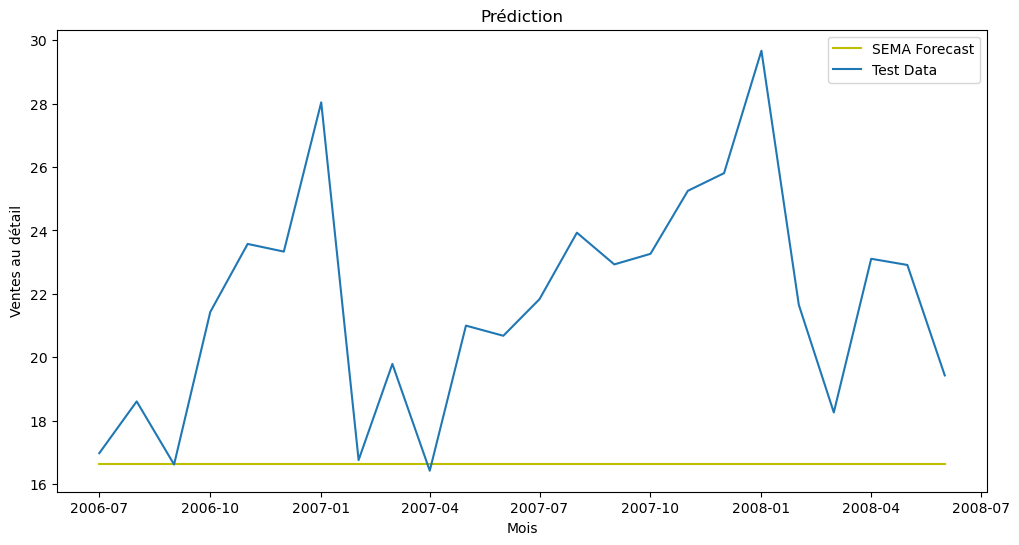

In [14]:
# SEMA
sema = SimpleExpSmoothing(train).fit()
sema_forecast = sema.forecast(len(test))
#sema_forecast.head()

# Visualisation des données prévisionnelles
forecast_plot(forecast_data = sema_forecast,forecast_label = 'SEMA Forecast' )

In [15]:
# Ajout du resultat au dataframe Precision
sema_acc = forcast_accuracy(sema_forecast, test.value)
Precision['SEMA ACC'] =  sema_acc
Precision

,NAÏVE ACC,SEMA ACC
RMSE,3.969457,6.142934


#### <a name="Holt-WintersMethod">2 - Méthode de la moyenne mobile exponentielle Holt-Winters


In [16]:
# Definissons la méthode de la moyenne mobile exponentielle Holt-Winters
method = ['ADD','MUL']
for trend in method:
    for seasonal in method:
        exponential = ExponentialSmoothing(train, seasonal_periods=12, trend = trend, seasonal= seasonal).fit()
        exponential_forecast = exponential.forecast(len(test))
        Precision[trend+'_'+seasonal+'_'+'ACC']= forcast_accuracy(exponential_forecast, test.value)

Precision

,NAÏVE ACC,SEMA ACC,ADD_ADD_ACC,ADD_MUL_ACC,MUL_ADD_ACC,MUL_MUL_ACC
RMSE,3.969457,6.142934,3.105467,2.971185,2.648327,2.3696


D'après les précisons ci)dessus, la méthode de Holt-Winters à tendance multiplicative et à saisonnalité multiplicative semble meilleur pour la prévision, donc utilisons là pour notre prédiction.

In [17]:
# Utilisons la méthode de Holt-Winters à tendance multiplicative et à saisonnalité multiplicative pour la prévision.
exponential = ExponentialSmoothing(train, seasonal_periods=12, trend='MUL', seasonal='MUL').fit()
exponential_forecast = exponential.forecast(len(test))

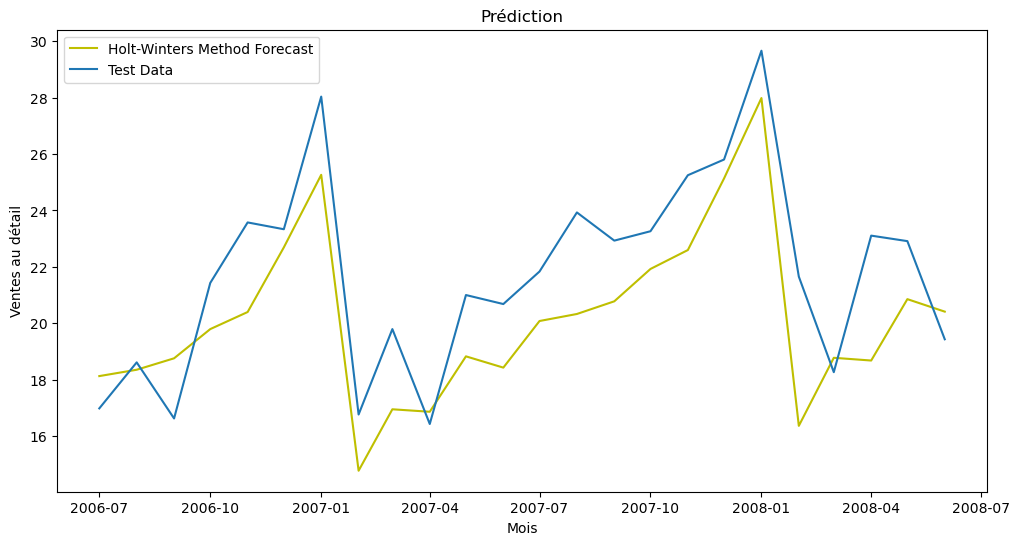

In [18]:
# Visualisation des données prévisionnelles exponentielle
forecast_plot(forecast_data = exponential_forecast,forecast_label = 'Holt-Winters Method Forecast')

### <a name="ARIMAForecast">c - ARIMA Forecast

>ARIMA est l'abréviation de Autoregressive Integrated Moving Average Model. Il appartient à une classe de modèles qui explique une série temporelle donnée sur la base de ses propres valeurs passées, c'est-à-dire ses propres retards et les erreurs de prévision retardées. L'équation peut être utilisée pour prévoir les valeurs futures. Toute série temporelle "non saisonnière" qui présente des caractéristiques et qui n'est pas un bruit blanc aléatoire peut être modélisée par des modèles ARIMA.
Ainsi, ARIMA, abréviation de AutoRegressive Integrated Moving Average, est un algorithme de prévision basé sur l'idée que les informations contenues dans les valeurs passées de la série chronologique peuvent être utilisées seules pour prédire les valeurs futures.
Les modèles ARIMA sont spécifiés par trois paramètres d'ordre : **(p, d, q)**,
où :

>1. `p` est l'ordre du terme AR
>2. `q` est l'ordre du terme MA
>3. `d` est le nombre de différenciations nécessaires pour rendre la série temporelle stationnaire.

>Afin de pouvoir utiliser le modèle ARIMA, trois grandes questions se posent :
>1. **Comment trouver l'ordre de différentiation (d) dans un modèle ARIMA ?**
>2. **Comment trouver l'ordre du terme AR (p) ?**
>3. **Comment trouver l'ordre du terme MA (q)**

#### **1 - Comment trouver l'ordre de différentiation (d) dans un modèle ARIMA ?**
Comme indiqué précédemment, le but de la différenciation est de rendre la série temporelle stationnaire. Mais nous devons faire attention à ne pas trop différencier les séries.

Vérifions si la série est stationnaire en utilisant le test de Dickey Fuller augmenté (test ADF). La raison en est que nous n'avons besoin de différencier que si la série est non stationnaire. Dans le cas contraire, aucune différenciation n'est nécessaire, c'est-à-dire que d=0. Ainsi, si la valeur p du test est inférieure au seuil de signification (0,05), on en déduisons que la série chronologique est stationnaire.


In [19]:
resultat = adfuller(medoc_df.value.dropna())
print('ADF Statistic: %f' % resultat[0])
print('p-value: %f' % resultat[1])

ADF Statistic: 3.145186
p-value: 1.000000


Puisque la valeur p(1.00) est supérieure au niveau de signification(0.05), différencions les séries et voyons à quoi ressemble le graphique d'autocorrélation

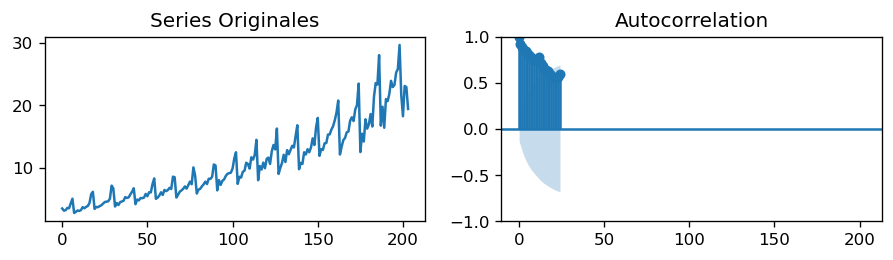

In [20]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

# Series Originales
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(medoc_df.value); axes[0].set_title('Series Originales')
plot_acf(medoc_df.value, ax=axes[1])

plt.show()

##### Différentiel de 1er ordre

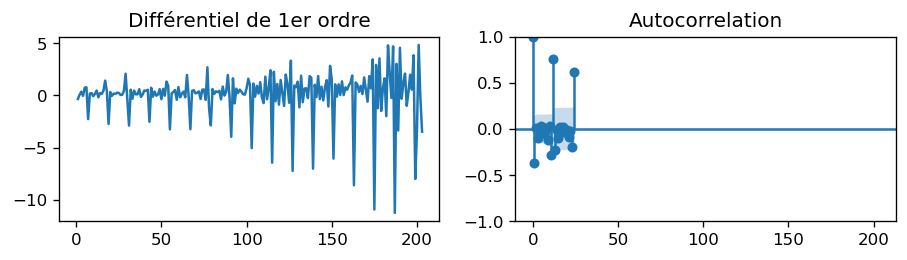

In [21]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})


# Différentiel de 1er ordre
fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(medoc_df.value.diff()); axes[0].set_title('Différentiel de 1er ordre')
plot_acf(medoc_df.value.diff().dropna(), ax=axes[1])

plt.show()

In [22]:
result = adfuller(medoc_df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.495172
p-value: 0.116653


La série étant toujours non stationnaire passons à au différentiel de deuxième ordre.

##### Différentiel de 2nd ordre

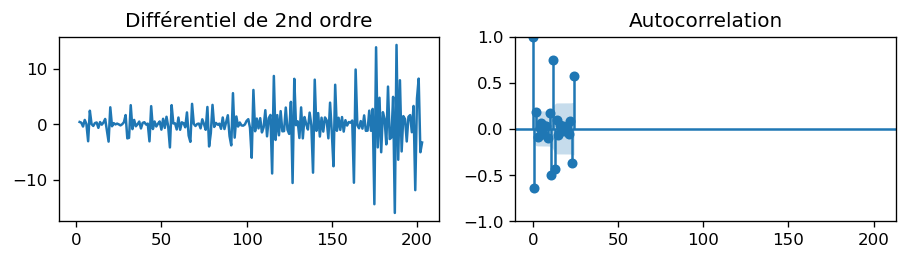

In [23]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

# Différentiel de 2nd ordre
fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(medoc_df.value.diff().diff()); axes[0].set_title('Différentiel de 2nd ordre')
plot_acf(medoc_df.value.diff().diff().dropna(), ax=axes[1])

plt.show()

In [24]:
result = adfuller(medoc_df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.292305
p-value: 0.000000


La série chronologique est desormais stationnaire.


#### **2 - Comment trouver l'ordre du terme AR (p) ?**
L'étape suivante consiste à déterminer si le modèle nécessite des termes AR. Nous trouverons le nombre requis de termes AR en inspectant le graphique d'autocorrélation partielle (PACF).
L'autocorrélation partielle peut être imaginée comme la corrélation entre la série et son retard, après avoir exclu les contributions des retards intermédiaires. Ainsi, le PACF traduit en quelque sorte la corrélation pure entre un retard et la série. De cette façon, nous saurons si ce retard est nécessaire dans le terme AR ou non.
L'autocorrélation partielle du retard (k) d'une série est le coefficient de ce retard dans l'équation d'autorégression de Y.


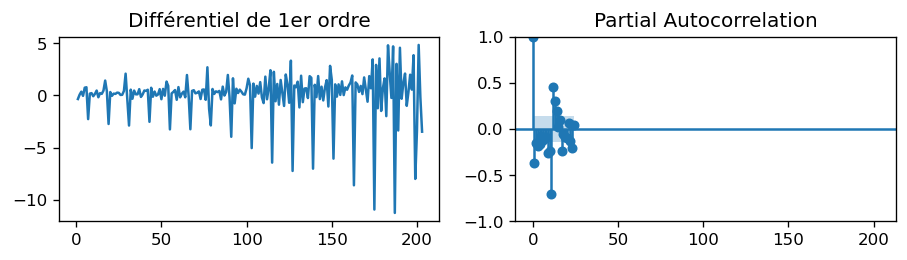

In [25]:
# Plot PACF de la première série différentiée
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(medoc_df.value.diff()); axes[0].set_title('Différentiel de 1er ordre')
axes[1].set(ylim=(0,5))
plot_pacf(medoc_df.value.diff().dropna(), ax=axes[1])

plt.show()

Nous pouvons voir que le PACF lag 1 est assez significatif puisqu'il est bien au-dessus de la ligne de signification. Nous allons donc fixer la valeur de p à 1.

#### **3 - Comment trouver l'ordre du terme MA (q)**

Tout comme nous avons examiné le graphique PACF pour le nombre de termes AR, nous allons examiner le graphique ACF pour le nombre de termes MA. Un terme MA est techniquement, l'erreur de la prévision retardée.

L'ACF indique combien de termes MA sont nécessaires pour éliminer toute autocorrélation dans la série stationnarisée.

Voyons le graphique d'autocorrélation de la série différentiée.


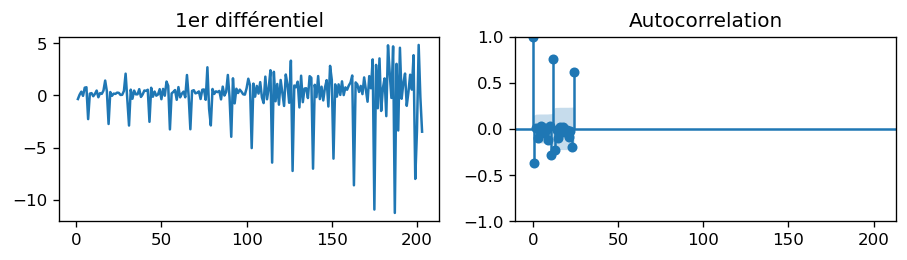

In [26]:
plt.rcParams.update({'figure.figsize':(9,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(medoc_df.value.diff()); axes[0].set_title('1er différentiel')
axes[1].set(ylim=(0,1.2))
plot_acf(medoc_df.value.diff().dropna(), ax=axes[1])

plt.show()

Nous pouvons voir que quelques retards sont bien au-dessus de la ligne de signification. Nous fixerons donc q à 2. En cas de doute, nous opterons pour le modèle le plus simple qui explique suffisamment le Y.


#### **4 - Construction du modèle ARIMA**

Maintenant, que nous avons déterminé les valeurs de p, d et q. Nous avons tout ce qu'il faut pour ajuster le modèle ARIMA. Nous allons utiliser l'implémentation ARIMA() du paquetage statsmodels.


In [ ]:
#!pip3 install pyramid-arima 
from statsmodels.tsa.arima_model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary().tables[0])
print(model_fit.summary().tables[1])

Le coefficient du terme MA2 est proche de zéro et la valeur P dans la colonne 'P>|z|' est hautement insignifiante. Idéalement, elle devrait être inférieure à 0,05 pour que le X respectif soit significatif.

Nous allons donc reconstruire le modèle sans le terme MA2.


In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary().tables[0])
print(model_fit.summary().tables[1])

L'AIC du modèle a légèrement diminué, ce qui est bon. Les p-values des termes AR1 et MA1 se sont améliorées et sont désormais < 0,05.

Traçons les résidus pour nous assurer qu'il n'y a pas de modèle (c'est-à-dire, cherchons une moyenne et une variance constantes).


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", color ='g', ax=ax[0])
residuals.plot(kind='kde', color ='g',title='Density', ax=ax[1])
plt.show()

Les erreurs résiduelles semblent correctes avec une moyenne proche de zéro et une variance uniforme. Traçons les valeurs réelles par rapport aux valeurs ajustées en utilisant plot_predict().


In [ ]:
# Réel vs ajusté
model_fit.plot_predict(dynamic=False)
plt.show()

Nous avons un modèle ARIMA acceptable. Sauf nous ne pouvons pas dire qu'il s'agit du meilleur modèle ARIMA car nous n'avons pas réellement fait de prévisions dans le futur et comparé les prévisions avec les performances réelles.

Ainsi, la véritable validation dont nous avons besoin maintenant est la validation croisée hors du temps.

Pour ce faire, nous devons l'utiliser sur l'ensemble de données de formation et de test diviser au préable en deux parties de séries temporelles contiguës dans une proportion raisonnable basée sur la fréquence temporelle pour la prévions et tracer cela


In [ ]:
# Construction du modèle
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Prévision
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Sauvegarder dans une série pandas
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Traçons
plt.figure(figsize=(11,3), dpi=100)
plt.plot(train, label='Formation')
plt.plot(test, label='Réel')
plt.plot(fc_series, label='Prévision')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Prévision et Réalité')
plt.legend(loc='upper left', fontsize=8)
plt.show()

D'après le graphique ci-dessus, le modèle ARIMA(1,1,1) semble prévoir une prévision correcte. Les valeurs réelles observées se situent dans la bande de confiance de 95%.

Mais, nous pouvons voir que les prévisions prédites sont constamment inférieures aux valeurs réelles. Cela signifie qu'en ajoutant une petite constante à notre prévision, la Precision sera certainement améliorée.

Donc, dans ce cas, nous devrions augmenter l'ordre de différentiation à deux (d=2) et augmenter itérativement p et q jusqu'à 3 pour voir quel modèle donne le moins d'AIC et aussi chercher un graphique qui donne des réalisations et des prévisions plus proches.

Tout en faisant cela, on garde un œil sur les valeurs P des termes AR et MA dans le résumé du modèle. Elles doivent être proches de zéro, idéalement, inférieures à 0,05.


In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1) 
print(fitted.summary().tables[0]) 
print(fitted.summary().tables[1])

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(11,3), dpi=100)
plt.plot(train, label='Formation')
plt.plot(test, label='Réel')
plt.plot(fc_series, label='Prévision')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Prévision et Réalité')
plt.legend(loc='upper left', fontsize=8)
plt.show()

L'AIC est passé de 843 à 716, ce qui est bien mais pas assez. Et à noté aussi que la plupart du temps, les valeurs p des termes X sont inférieures à < 0,05, ce qui est excellent. Donc, dans l'ensemble, ce modèle est acceptable mais calculons sa metrique pour le comparer aux autres déja vu.

In [ ]:
Arima_acc = forcast_accuracy(fc, test.values)
Precision['ARIMA ACC'] =  Arima_acc
Precision

### <a name="SARIMAForecast">d - SARIMA Forecast

Le modèle ARIMA ordinaire a un problème, il ne supporte pas la saisonnalité.

Si la série temporelle a une saisonnalité définie, nous devons opter pour le modèle ARIMA saisonnier (en abrégé SARIMA) qui utilise la différenciation saisonnière.

La différenciation saisonnière est similaire à la différenciation ordinaire, mais, au lieu de soustraire des termes consécutifs, nous soustrayons la valeur de la saison précédente.

Ainsi, le modèle sera représenté par SARIMA (p, d, q) x (P, D, Q), où P, D et Q sont respectivement les termes SAR, l'ordre de la différenciation saisonnière et SMA et 'x' est la fréquence de la série temporelle. Si le modèle présente des modèles saisonniers bien définis, il faut appliquer D=1 pour une fréquence 'x' donnée.

Nous devrions définir les paramètres du modèle de sorte que D ne dépasse jamais un. Et le différentiel total 'd + D' ne dépasse jamais 2. Nous devons essayer de ne conserver que les termes SAR ou SMA si le modèle comporte des composantes saisonnières.

Maintenant, nous allons construire un modèle SARIMA sur l'ensemble de données de séries temporelles.


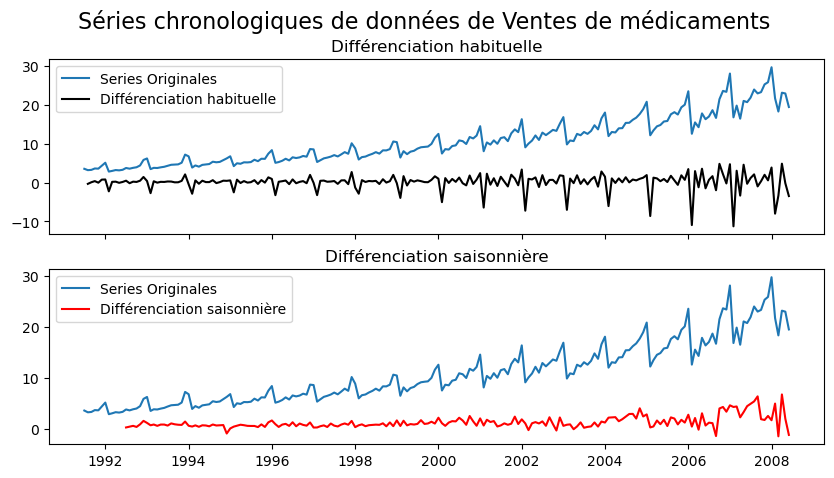

In [36]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Différenciation habituelle
axes[0].plot(df, label='Series Originales')
axes[0].plot(df.diff(1), label='Différenciation habituelle', color='black')
axes[0].set_title('Différenciation habituelle')
axes[0].legend(loc='upper left', fontsize=10)


# Différenciation saisonnière
axes[1].plot(df, label='Series Originales')
axes[1].plot(df.diff(12), label='Différenciation saisonnière', color='red')
axes[1].set_title('Différenciation saisonnière')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Séries chronologiques de données de Ventes de médicaments', fontsize=16)
plt.show()

Nous pouvons voir que les pics saisonniers sont intacts après avoir appliqué la différenciation habituelle (lag 1). Alors qu'ils sont rectifiés après la différenciation saisonnière.

Maintenant, construisons le modèle SARIMA en utilisant auto_arima() de pmdarima. Pour ce faire, nous devons définir seasonal=True, définir la fréquence m=12 pour les séries mensuelles et appliquer D=1.


In [39]:
# Seasonal - fit stepwise auto-ARIMA
#%%capture
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.3/608.3 kB 849.4 kB/s eta 0:00:00a 0:00:01


In [40]:
import pmdarima as pm
sarima_model = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=3.11 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.09 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.496, Time=4.56 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.32 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.14 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.47 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

In [41]:
print(sarima_model.summary().tables[0])
print(sarima_model.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.394
Date:                              Mon, 23 Jan 2023   AIC                            528.788
Time:                                      18:58:49   BIC                            548.333
Sample:                                  07-01-1991   HQIC                           536.704
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1638      0.097      1.696      0.090      -0.026       0.353
ar.L1          0.09

Le modèle a estimé l'AIC et les valeurs P des coefficients semblent significatives. Regardons le graphique de diagnostic des résidus.

Le meilleur modèle SARIMAX(1,0,2)x(1,1,2,12) a un AIC de 524.05 et les valeurs P sont bonnes.

Faisons des prévisions pour les 24 prochains mois.


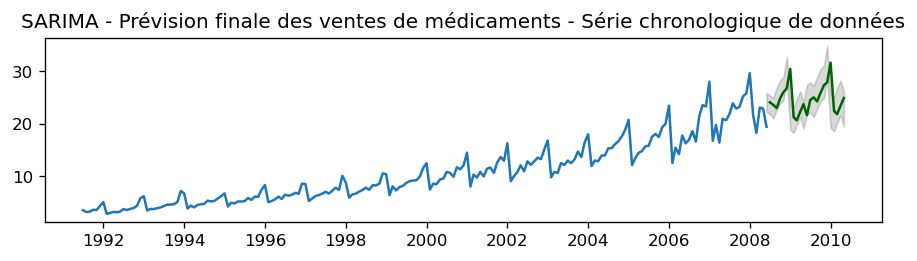

In [42]:
# Prévisions
n_periods = 24 #len(test)
fitted, confint = sarima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# Créer des séries pour la visualisation
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Visualiser
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Prévision finale des ventes de médicaments - Série chronologique de données")
plt.show()

In [43]:
sarima_acc = forcast_accuracy(fitted.values, test.values)
Precision['SARIMA ACC'] = sarima_acc
Precision

,NAÏVE ACC,SEMA ACC,ADD_ADD_ACC,ADD_MUL_ACC,MUL_ADD_ACC,MUL_MUL_ACC,SARIMA ACC
RMSE,3.969457,6.142934,3.105467,2.971185,2.648327,2.3696,5.24135


# <a name="TimeSeriesModelingwithDeepLearning">4. Modélisation des séries temporelles avec le Deep Learning

## <a name="Preprocessing">1 - Prétraitement des données

In [44]:
# Fenêtre glissante
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for i in range(len(x) - n_steps):
        v = x.iloc[i:(i + n_steps)].values
        x_ts.append(v)
        w = x.iloc[i + n_steps].values
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

Utilisons la fonction de fenêtre glissante

In [45]:
n_steps = 3
n_features = 1

# convert to a time series dimension: [samples, n_steps, n_features]
x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print()
#for i in range(len(x_train)):
#  print(x_train[i],y_train[i])

(177, 3, 1) (177, 1)
(21, 3, 1) (21, 1)


## <a name="MLP">2 - MLP

### <a name="ModelingMLP">a - Modélisation

In [46]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_dim=n_steps))
mlp_model.add(Dense(1))
mlp_model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

In [47]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


### <a name="TrainingMLP">b - Formation

In [48]:
# Ajustement du modèle
mlp_history = mlp_model.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
5/5 [==============================] - 2s 67ms/step - loss: 57.6646 - val_loss: 174.1901
Epoch 2/500
5/5 [==============================] - 0s 17ms/step - loss: 47.2013 - val_loss: 142.3171
Epoch 3/500
5/5 [==============================] - 0s 13ms/step - loss: 38.1908 - val_loss: 114.5797
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 30.4491 - val_loss: 90.9703
Epoch 5/500
5/5 [==============================] - 0s 13ms/step - loss: 23.9015 - val_loss: 71.1756
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 18.4528 - val_loss: 54.9003
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 14.0051 - val_loss: 41.8656
Epoch 8/500
5/5 [==============================] - 0s 13ms/step - loss: 10.4627 - val_loss: 31.7491
Epoch 9/500
5/5 [==============================] - 0s 12ms/step - loss: 7.7348 - val_loss: 24.2273
Epoch 10/500
5/5 [==============================] - 0s 13ms/step - loss: 5.7133 - val_loss: 18.914

### <a name="EvaluationMLP">c - Evaluation

In [49]:
y_predmlp = mlp_model.predict(x_test)

1/1 [==============================] - 0s 134ms/step


In [50]:
print("Données de Test\t\tDonnées prédites")
for i in range(len(y_test )):
    print(f"{y_test[i]}\t\t{y_predmlp[i]}")

Données de Test		Données prédites
[21.430241]		[18.842709]
[23.575517]		[19.95959]
[23.334206]		[13.698783]
[28.038383]		[23.407888]
[16.763869]		[24.260986]
[19.792754]		[19.773275]
[16.427305]		[19.753572]
[21.000742]		[18.692673]
[20.681002]		[20.871763]
[21.83489]		[15.369942]
[23.93020353]		[23.28588]
[22.93035694]		[21.772112]
[23.26333992]		[24.453161]
[25.25003022]		[25.605257]
[25.80609]		[24.989426]
[29.665356]		[25.044006]
[21.654285]		[26.114742]
[18.264945]		[25.013502]
[23.107677]		[19.019064]
[22.91251]		[22.932896]
[19.43174]		[17.095821]


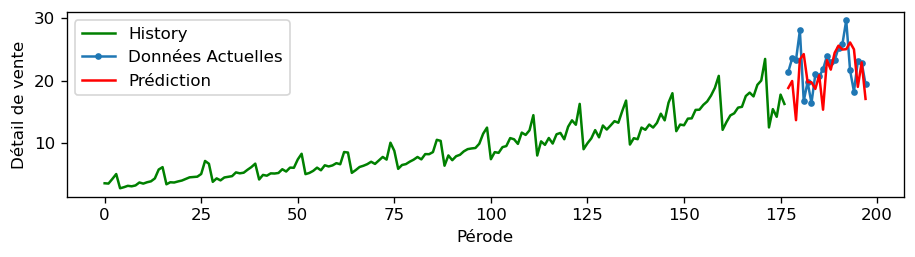

In [52]:
# Visualisation
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Données Actuelles")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_predmlp, 'r', label="Prédiction")
plt.ylabel('Détail de vente')
plt.xlabel('Période')
plt.legend()
plt.show();

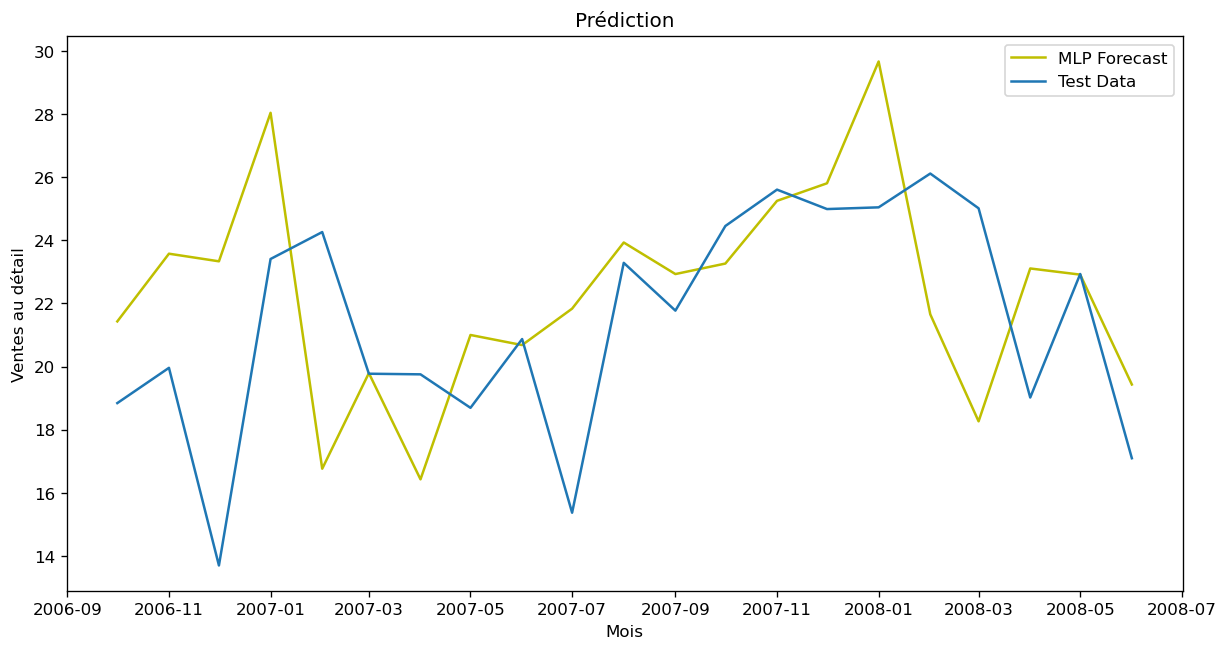

In [53]:
# Visualisation de la prédiction
forecast_plot(forecast_data = y_test, forecast_label = 'MLP Forecast',test_time=test_time[3:],test_data=y_predmlp)

In [54]:
# Accuracy
#mlp_train_result = forcast_accuracy(train_Precision_rescale,train_label_rescale)
mlp_forecast = forcast_accuracy(y_predmlp,y_test)
#print('Train Score: %.2f RMSE' % (mlp_train_result))
#print('Test Score: %.2f RMSE' % (mlp_forecast_result))

Precision['MLP ACC'] =  mlp_forecast
Precision

,NAÏVE ACC,SEMA ACC,ADD_ADD_ACC,ADD_MUL_ACC,MUL_ADD_ACC,MUL_MUL_ACC,SARIMA ACC,MLP ACC
RMSE,3.969457,6.142934,3.105467,2.971185,2.648327,2.3696,5.24135,4.148541


## <a name="LSTM">3 - LSTM

### <a name="ModelingLSTM">a - Modélisation

In [55]:
# define model
lstm_model = Sequential()
lstm_model.add(LSTM(units=256, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer=Adam(0.001))

In [56]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


### <a name="FormationLSTM">b - Formation

In [57]:
# fit model
lstm_history = lstm_model.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
5/5 [==============================] - 3s 119ms/step - loss: 78.3932 - val_loss: 230.8194
Epoch 2/500
5/5 [==============================] - 0s 27ms/step - loss: 63.3124 - val_loss: 175.4239
Epoch 3/500
5/5 [==============================] - 0s 27ms/step - loss: 47.3934 - val_loss: 109.7519
Epoch 4/500
5/5 [==============================] - 0s 27ms/step - loss: 28.8861 - val_loss: 39.1016
Epoch 5/500
5/5 [==============================] - 0s 27ms/step - loss: 11.3123 - val_loss: 44.7976
Epoch 6/500
5/5 [==============================] - 0s 27ms/step - loss: 13.9900 - val_loss: 178.3774
Epoch 7/500
5/5 [==============================] - 0s 27ms/step - loss: 8.5891 - val_loss: 95.0212
Epoch 8/500
5/5 [==============================] - 0s 27ms/step - loss: 5.6147 - val_loss: 37.8280
Epoch 9/500
5/5 [==============================] - 0s 27ms/step - loss: 6.9122 - val_loss: 26.5657
Epoch 10/500
5/5 [==============================] - 0s 27ms/step - loss: 6.8879 - val_loss: 30.340

### <a name="EvaluationLSTM">c - Evaluation

In [58]:
y_predlstm = lstm_model.predict(x_test)

1/1 [==============================] - 0s 310ms/step


In [59]:
print("Données de Test\t\tDonnées prédites")
for i in range(len(y_test )):
    print(f"{y_test[i]}\t\t{y_predlstm[i]}")

Données de Test		Données prédites
[21.430241]		[17.433699]
[23.575517]		[18.675882]
[23.334206]		[16.033592]
[28.038383]		[20.985495]
[16.763869]		[23.254347]
[19.792754]		[17.750511]
[16.427305]		[20.108871]
[21.000742]		[16.138855]
[20.681002]		[19.006325]
[21.83489]		[15.859046]
[23.93020353]		[21.272518]
[22.93035694]		[21.049269]
[23.26333992]		[21.324644]
[25.25003022]		[23.347624]
[25.80609]		[23.054506]
[29.665356]		[22.437845]
[21.654285]		[24.735003]
[18.264945]		[22.258694]
[23.107677]		[21.48849]
[22.91251]		[20.57468]
[19.43174]		[17.076546]


In [60]:
#len(test_time[:len(y_test)])
len(y_test)

21

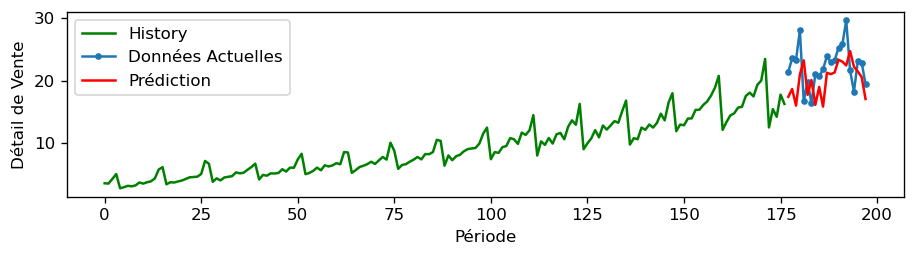

In [61]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Données Actuelles")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_predlstm, 'r', label="Prédiction")
plt.ylabel('Détail de Vente')
plt.xlabel('Période')
plt.legend()
plt.show();

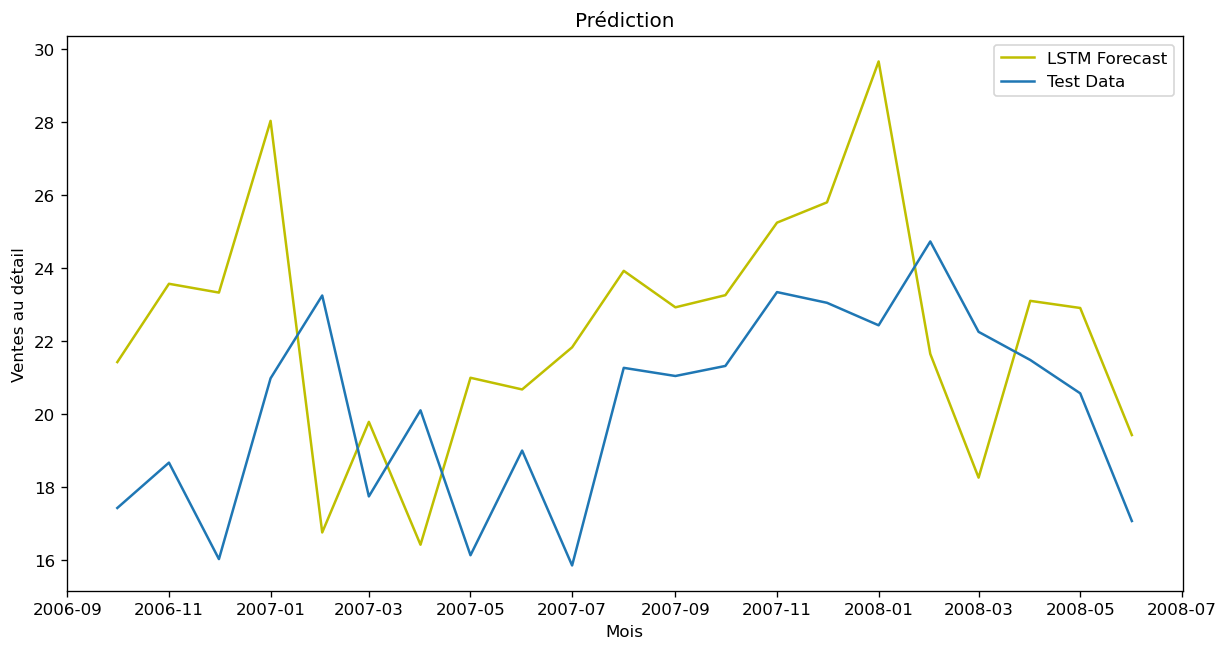

In [62]:
# Visualisation de la prédiction
forecast_plot(forecast_data = y_test, forecast_label = 'LSTM Forecast',test_time=test_time[3:],test_data=y_predlstm)

In [63]:
# Accuracy
lstm_forecast = forcast_accuracy(y_predlstm,y_test)
#print('Test Score: %.2f RMSE' % (lstm_forecast))

Precision['LSTM ACC'] =  lstm_forecast
Precision


,NAÏVE ACC,SEMA ACC,ADD_ADD_ACC,ADD_MUL_ACC,MUL_ADD_ACC,MUL_MUL_ACC,SARIMA ACC,MLP ACC,LSTM ACC
RMSE,3.969457,6.142934,3.105467,2.971185,2.648327,2.3696,5.24135,4.148541,4.264403


# <a name="Conclusion">5. Conclusion

De ce qui precède, il faut faut retenir que le meilleur modèle est la `méthode de Holt-Winters` à tendance multiplicative et à saisonnalité multiplicative, car il a la meilleure mésure de prédiction en terme d'Erreur quadratique moyenne (`RMSE`).

Mais n'oublions pas que cela est valable seulement sur l'echantillons du dataset utilisé. Car sur une plus longue durée ou un autre dataset il est fort probable que ça soit un autre, tout dépend uniquement des données que nous avons.

In [64]:
Precision

,NAÏVE ACC,SEMA ACC,ADD_ADD_ACC,ADD_MUL_ACC,MUL_ADD_ACC,MUL_MUL_ACC,SARIMA ACC,MLP ACC,LSTM ACC
RMSE,3.969457,6.142934,3.105467,2.971185,2.648327,2.3696,5.24135,4.148541,4.264403
